In [ ]:
#default_exp reachability

In [ ]:
#hide_output
%load_ext autoreload
%autoreload 2

# Reachability queries
> Finding if one vertex in the DAG is reachable from another, with the help of various reachability indexes (labels)

Imports for the `git_commit_graph_ext.reachability` module generated from this notebook

In [ ]:
#export
from collections import deque

## Reachability queries with topological levels and min-post intervals

Start with what was defined in the original Google Colab notebook, called there `generic_is_reachable()`.

It will not be using FELINE index though, as it seems that this type of index is not a good fit for large commit graphs.

### Recursive chatty version (levels + min-post) - `generic_is_reachable`

This recursive version is based on the Algorithm 3 from the FELINE paper, translated from pseudocode to Python (and NetworkX).

In [ ]:
#export
def generic_is_reachable(DG, u, v,
                         II=None, l=None,
                         stats=None, verbose=None):
    """Whether in graph DG $v$ is reachable from $u$, utilizing given indices
  
    Given (u, v) ∈ V², two vertices in the DAG given by the DG parameter,
    calculate r(u,v), that is whether vertex v is reachable from vertex u.
  
    This is based on the Algorithm 3 from FELINE paper, translated from pseudocode
    to Python (and NetworkX).
  
    NOTE: this is a straightforward recursive version of the function.
  
    Parameters
    ----------
    DG : NetworkX digraph
         Directed acyclic graph.
  
    u : node
        Source node.
  
    v : node
        Target node.
  
    II : dict or None, optional (default=None)
        A dictionary with nodes as keys and min-post interval index as values
        (2-element lists, representing intervals).
  
    l : dict or None, optional (default=None)
        A dictionary with nodes as keys and backward topological vertex level as values
        (vertex level is also known as generation number).
  
    stats : dict or None, optional (default=None)
        A dictionary gathering statistics about calls.  Currently supported
        are:
         * 'access' key, counting the number of intermediate vertices it
           checks / accesses
         * 'level' key, storing list of vertices where level index cut off
           further walk (further search)
         * 'walk' key, with list of all vertices walked, in order
         * 'min-post' key, storing the vertex at which positive-cut
           min-post interval cut-off the need for further search
  
    verbose : bool or None, optional (default=None)
        Whether to print debugging information.  If set to None (the default),
        it prints debugging information if stats parameter is set.
  
    Returns
    -------
    r(u,v) : bool
        Whether v is reachable from u
    """
    if isinstance(stats, dict):
        if verbose is None:
            verbose = True
        stats.setdefault('access', 0)
        stats.setdefault('level', [])
        stats.setdefault('walk', [])

        stats['walk'].append(u)

    if u == v:
        return True

    # II_v ⊆ II_u <=> π(v) ∈ II_u (positive cut)
    # II_v = [min_{w∈T_v}(π(w)),π(v)]
    if II and II[u][0] <= II[v][1] <= II[u][1]:
        if verbose:
            print('%s->%s min-post resolved %s ∈ %r ⊆ %r' %
                  (u, v, II[v][1], II[v], II[u]))
        if isinstance(stats, dict):
            stats['min-post'] = u
        return True

    # debugging
    if verbose:
        if l and not l[v] < l[u]:
            print('%s->%s level cut ¬%d < %d' %
                  (u, v, l[v], l[u]))

    # l_v < l_u (no negative cut)
    if (l and l[v] < l[u]) or (not l):
        # debugging
        if verbose:
            print('%s->%r' % (u, list(DG.successors(u))))
        # worst case analysis, no short-circuit
        result = False
        for w in DG.successors(u):
            if isinstance(stats, dict):
                stats['access'] += 1

            # recursion
            if generic_is_reachable(DG, w, v, II=II, l=l,
                                    stats=stats, verbose=verbose):
                # average case
                # return True
                # worst case analysis
                result = True

        # worst case analysis
        if result:
            return True

    else:
        # negative cut, but which one
        if isinstance(stats, dict):
            if l and not l[v] < l[u]:
                stats['level'].append(u)

    return False

Test that everything works.  For this we need example graphs, and a way to compute reachability levels

In [ ]:
# example graphs
import git_commit_graph_ext.example_graphs as graphs
# reachability indexes
from git_commit_graph_ext.labelling.levels import *
from git_commit_graph_ext.labelling.dfs_intervals import *
# plotting, for visualizations
import matplotlib.pyplot as plt

Use the example graph from the PReaCH paper for testing

In [ ]:
%%time
# lazy generation of the graph
try:
    ch
except NameError:
    ch=graphs.RCH_graph()

recalculate = True
if recalculate or not hasattr(ch, 'lvl'):
    ch.lvl = find_levels(ch) # TODO: pre-computed levels are forward levels
if recalculate or not hasattr(ch, 'mpi'):
    ch.mpi = find_dfs_intervals(ch)

#print('%r' % ch)
print('graph has {} nodes and {} edges'.format(ch.number_of_nodes(), ch.number_of_edges()))
print('nodes: {!r}'.format(list(ch.nodes())))
print('it has the following attributes:')
for (attr,val) in ch.__dict__.items():
  if isinstance(val, dict) and not attr.startswith('_'):
    #print('- %s: %r' % (attr, ch.__dict__[attr]))
    print('- %s' % attr)

graph has 17 nodes and 19 edges
nodes: ['a', 'e', 'b', 'f', 'g', 'c', 'h', 'i', 'd', 'j', 'o', 'k', 'l', 'm', 'n', 'p', 'q']
it has the following attributes:
- graph
- lvl
- pos
- mpi
Wall time: 11 ms


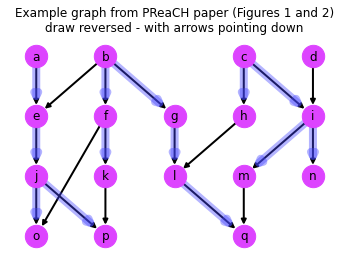

In [ ]:
plt.axis("off")
plt.title('Example graph from PReaCH paper (Figures 1 and 2)\ndraw reversed - with arrows pointing down')
nx.draw_networkx(ch,pos={key:(value[0],-value[1]) for (key,value) in ch.pos.items()},
                 node_size=500,width=2.0,node_color='#dd44ff')
nx.draw_networkx_edges(ch,pos={key:(value[0],-value[1]) for (key,value) in ch.pos.items()},
                       edgelist=find_dfs_spanning(ch),
                       node_size=500,
                       width=8.0,edge_color='#4444ff',alpha=0.4,arrowstyle='->')
plt.show()

In [ ]:
# test unreachable
stats = {}
result = generic_is_reachable(ch, 'a', 'g', stats=stats)
print('r(%s,%s)=%r in %d steps (naive)\n  %r\n' %
      ('a', 'g', result, stats['access'], stats))
stats = {}
result = generic_is_reachable(ch, 'a', 'g', II=ch.mpi, stats=stats)
print('r(%s,%s)=%r in %d steps (min-post)\n  %r\n' %
      ('a', 'g', result, stats['access'], stats))
stats = {}
result = generic_is_reachable(ch, 'a', 'g', l=ch.lvl, stats=stats)
print('r(%s,%s)=%r in %d steps (level)\n  %r' %
      ('a', 'g', result, stats['access'], stats))

a->['e']
e->['j']
j->['o', 'p']
o->[]
p->[]
r(a,g)=False in 4 steps (naive)
  {'access': 4, 'level': [], 'walk': ['a', 'e', 'j', 'o', 'p']}

a->['e']
e->['j']
j->['o', 'p']
o->[]
p->[]
r(a,g)=False in 4 steps (min-post)
  {'access': 4, 'level': [], 'walk': ['a', 'e', 'j', 'o', 'p']}

a->['e']
e->g level cut ¬2 < 2
r(a,g)=False in 1 steps (level)
  {'access': 1, 'level': ['e'], 'walk': ['a', 'e']}


In [ ]:
# test reachable
stats = {}
u='b'
v='o'
#u='c'
#v='q'
result = generic_is_reachable(ch, u, v, stats=stats)
print('r(%s,%s)=%r in %d steps (naive)\n  %r\n' %
      (u, v, result, stats['access'], stats))
stats = {}
result = generic_is_reachable(ch, u, v, II=ch.mpi, stats=stats)
print('r(%s,%s)=%r in %d steps (min-post)\n  %r\n' %
      (u, v, result, stats['access'], stats))
stats = {}
result = generic_is_reachable(ch, u, v, l=ch.lvl, stats=stats)
print('r(%s,%s)=%r in %d steps (level)\n  %r\n' %
      (u, 'g', result, stats['access'], stats))
stats = {}
result = generic_is_reachable(ch, u, v, II=ch.mpi, l=ch.lvl, stats=stats)
print('r(%s,%s)=%r in %d steps (min-post + level)\n  %r' %
      (u, v, result, stats['access'], stats))

b->['e', 'f', 'g']
e->['j']
j->['o', 'p']
p->[]
f->['o', 'k']
k->['p']
p->[]
g->['l']
l->['q']
q->[]
r(b,o)=True in 11 steps (naive)
  {'access': 11, 'level': [], 'walk': ['b', 'e', 'j', 'o', 'p', 'f', 'o', 'k', 'p', 'g', 'l', 'q']}

b->['e', 'f', 'g']
e->o min-post resolved 1 ∈ [1, 1] ⊆ [1, 4]
f->['o', 'k']
k->['p']
p->[]
g->['l']
l->['q']
q->[]
r(b,o)=True in 8 steps (min-post)
  {'access': 8, 'level': [], 'walk': ['b', 'e', 'f', 'o', 'k', 'p', 'g', 'l', 'q'], 'min-post': 'e'}

b->['e', 'f', 'g']
e->['j']
j->['o', 'p']
p->o level cut ¬0 < 0
f->['o', 'k']
k->['p']
p->o level cut ¬0 < 0
g->['l']
l->['q']
q->o level cut ¬0 < 0
r(b,g)=True in 11 steps (level)
  {'access': 11, 'level': ['p', 'p', 'q'], 'walk': ['b', 'e', 'j', 'o', 'p', 'f', 'o', 'k', 'p', 'g', 'l', 'q']}

b->['e', 'f', 'g']
e->o min-post resolved 1 ∈ [1, 1] ⊆ [1, 4]
f->['o', 'k']
k->['p']
p->o level cut ¬0 < 0
g->['l']
l->['q']
q->o level cut ¬0 < 0
r(b,o)=True in 8 steps (min-post + level)
  {'access': 8, 'level': ['p', 

### DFS walk version (levels + min-post) - `generic_is_reachable_dfs`

The code below was called `generic_is_reachable_large_v1()` and aliased to `generic_is_reachable_large()` in the original Google Colab notebook (see the [index](index.ipynb) for reference); though the one below has had its support for FELINE labels removed.

In [ ]:
#export
def generic_is_reachable_dfs(DG, u, v,
                             II=None, l=None,
                             stats=None):
    """Whether in large graph DG $v$ is reachable from $u$, utilizing given indices
  
    Given (u, v) ∈ V², two vertices in the DAG given by the DG parameter,
    calculate r(u,v), whether vertex v is reachable from vertex u.
  
    This is non-recursive version of the function, without verbose mode,
    intended for larger graphs.  It travels the graph using depth-first search (DFS).
  
    Parameters
    ----------
    DG : NetworkX digraph
         Directed acyclic graph.
  
    u : node
        Source node.
  
    v : node
        Target node.
  
    II : dict or None, optional (default=None)
        A dictionary with nodes as keys and min-post interval index as values
        (2-element lists, representing intervals), e.g. result of
        find_dfs_intervals().
  
    l : dict or None, optional (default=None)
        A dictionary with nodes as keys and vertex level as values
        (vertex level is also known as generation number), e.g. result of
        find_levels().
  
    stats : dict or None, optional (default=None)
        A dictionary gathering statistics about calls.  Currently supported
        are:
         * 'access' key, counting the number of intermediate vertices it
           checks / accesses.
         * 'level-filter' key, storing nodes that level index stopped searching at
         * 'walk' key, storing all walked nodes
         * 'min-post' key, storing node where min-post filter found reachable
         * 'max-depth' key, with maximum stack depth
  
    Returns
    -------
    r(u,v) : bool
        Whether v is reachable from u
    """
    # initialize stats
    if isinstance(stats, dict):
        stats['access'] = 0
        if l:
            stats['level-filter'] = []
        stats['walk'] = []
        stats['max-depth'] = 0
        stats['visited-filter'] = 0

    # iteration in place of recursion
    stack = []
    visited = set()  # it somewhat duplicates stats['walk'] list
    while u is not None:

        # mark 'u' as visited
        visited.add(u)

        if isinstance(stats, dict):
            stats['walk'].append(u)
            stats['max-depth'] = max(stats['max-depth'], len(stack))

        # have we arrived at destination?
        if u == v:
            return True

        # II_v ⊆ II_u <=> π(v) ∈ II_u (positive cut)
        # II_v = [min_{w∈T_v}(π(w)), π(v)]
        if II and II[u][0] <= II[v][1] <= II[u][1]:
            if isinstance(stats, dict):
                stats['min-post'] = u
            return True

        # l_v < l_u (no negative cut; note: u != v)
        if (l and l[v] < l[u]) or (not l):

            # TODO: sort successors
            for w in DG.successors(u):
                if isinstance(stats, dict):
                    stats['access'] += 1

                if w not in visited:
                    stack.append(w)
                    # TODO: break out of loop, to have DFS
                    # TODO= needs to remember which successors visited
                elif isinstance(stats, dict):
                    stats['visited-filter'] += 1

        else:
            # negative cut, but which one
            if isinstance(stats, dict):
                if l and not l[v] < l[u]:
                    stats['level-filter'].append(u)

        # next iteration
        if stack:
            u = stack.pop()
        else:
            # return False only if there is nothing left to do
            return False
        # end while

    # haven't found v
    return False

Basic test that `generic_is_reachable_dfs()` works
(among others that there are no syntax errors).

In [ ]:
stats = {}
#u='b'
u='a'
v='o'

print('graph has {} nodes and {} edges'.format(ch.number_of_nodes(), ch.number_of_edges()))
print('nodes: {!r}'.format(list(ch.nodes())))
print('it has the following attributes:')
for (attr,val) in ch.__dict__.items():
  if isinstance(val, dict) and not attr.startswith('_'):
    #print('- %s: %r' % (attr, ch.__dict__[attr]))
    print('- %s' % attr)

result = generic_is_reachable_dfs(ch, u, v, II=ch.mpi, l=ch.lvl, stats=stats)
print('r(%s,%s)=%r in %d steps (min-post + level)\n  %r' %
      (u, v, result, stats['access'], stats))

graph has 17 nodes and 19 edges
nodes: ['a', 'e', 'b', 'f', 'g', 'c', 'h', 'i', 'd', 'j', 'o', 'k', 'l', 'm', 'n', 'p', 'q']
it has the following attributes:
- graph
- lvl
- pos
- mpi
r(a,o)=True in 0 steps (min-post + level)
  {'access': 0, 'level-filter': [], 'walk': ['a'], 'maxdepth': 0, 'visited-filter': 0, 'min-post': 'a'}


### BFS walk version, actively developed - `generic_is_reachable_bfs`

This is called `generic_is_reachable_large_bfs()` (where BFS = breadth-first search)
in the [Google Colab notebook](https://colab.research.google.com/drive/1V-U7_slu5Z3s5iEEMFKhLXtaxSu5xyzg#scrollTo=Zb8cvM3szzuu),
but with the support for FELINE index stripped,
and the support for PReaCH extensions to the min-post intervals index commented out;
the support for min-post graph intervals as negative-cut filters was kept (was part of PReaCH extension).

This code tries to be more generic by separating `reachable_positive_cut` and `reachable_negative_cut`
into their own functions, but they are still very much tied to given set of reachability indices.

Currently there is no way to add another index at later time (the design is not open to extensions),
but making something generic may be not necessary as it is mainly exploraatory notebook.
The code in Git would be written in C language, not in Python.

In [ ]:
#export
def reachable_positive_cut(u, v,
                           II=None,
                           stats=None):
    """Whether given indices say that $v$ is reachable from $u$

    Given (u, v) ∈ V², a positive cut happens if the reachability index
    implies that vertex v is reachable from vertex u.

        test(u,v) => r(u,v)

    Parameters
    ----------
    u : node
        Source node.

    v : node
        Target node.

    II : dict or None, optional (default=None)
        A dictionary with nodes as keys and min-post interval index as values
        (2-element lists, representing intervals), e.g. result of
        `find_dfs_intervals()`.

        TODO:
        -----
        Or a dictionary with nodes as keys and dict describing DFS-derived
        info, with keys such as 'min' and 'post' describing min-post interval,
        and 'f_min', 'f_gap' and 'p_tree' - like in PReaCH paper; e.g result
        of `find_dfs_intervals_extra()`.

    stats : dict or None, optional (default=None)
        A dictionary gathering statistics about calls (positive cuts).

    Returns
    -------
    test(u,v) : bool
        Whether index indicates that v is reachable from u
    """
    if stats is None:
        stats = {}
    # no data to indicate that v is reachable from u
    if not II:
        return False

    # find_dfs_intervals() case
    if isinstance(II[u], list):
        # II_v ⊆ II_u (positive cut)
        if II[u][0] <= II[v][1] <= II[u][1]:
            stats['positive-cut'] = {
                'type': 'min-post',
                'node': u
            }
            # print("%s -> %s: %d in [%d,%d]" % (u,v,II[v][1], II[u][0], II[u][1]))
            return True

    # find_dfs_intervals_extra() case
    else:
        # π(v) ∈ range(u)  ⇒  r(u,v)
        if II[u]['min'] <= II[v]['post'] <= II[u]['post']:
            stats['positive-cut'] = {
                'type': 'min-post(node)',
                'node': u
            }
            return True

        # elif II[u]['p_tree'] is not None:
        #    p = II[u]['p_tree']
        #    # r(u,p_tree) ∧ ϕ(v) ∈ range(p_tree)  ⇒  r(u,v)
        #    if II[p]['min'] <= II[v]['post'] <= II[p]['post']:
        #        stats['positive-cut'] = {
        #            'type': 'min-post(p_tree)',
        #            'p_tree': p,
        #            'node': u
        #        }
        #        return True

    # no positive cut
    return False


def reachable_negative_cut(u, v,
                           II=None, l=None,
                           stats=None):
    """Whether given indices say that $v$ is not reachable from $u$

    Given (u, v) ∈ V², a negative cut happens if the index implies that
    vertex v is not reachable from vertex u.

        r(u,v) => test(u,v)

    Parameters
    ----------
    u : node
        Source node.

    v : node
        Target node.

    II : dict or None, optional (default=None)
        A dictionary with nodes as keys and min-post interval index as values
        (2-element lists, representing intervals), e.g. result of
        `find_dfs_intervals()`.

        TODO:
        -----
        Or a dictionary with nodes as keys and dict describing DFS-derived
        info, with keys such as 'min' and 'post' describing min-post interval,
        and 'f_min', 'f_gap' and 'p_tree' - like in PReaCH paper; e.g result
        of `find_dfs_intervals_extra()`.

    l : dict or None, optional (default=None)
        A dictionary with nodes as keys and vertex level as values
        (vertex level is also known as generation number), e.g. result of
        `find_levels()`.

    stats : dict or None, optional (default=None)
        A dictionary gathering statistics about calls (negative cuts).

    Returns
    -------
    test(u,v) : bool
        Whether index indicates that v is not reachable from u
    """
    if stats is None:
        stats = {}
    # find all conditions that match
    # otherwise stats would depend on check order
    result = False  # no negative cut

    # we can use levels filter
    if l:
        # r(u,v)    ∧ u ≠ v  ⇒  l_v < l_u, thus
        # l_u ≤ l_v ∧ u ≠ v  ⇒  ¬r(u,v)
        if l[u] < l[v]:
            stats['negative-cut']['level_lite'].append(u)
            result = True

        if u != v and l[u] <= l[v]:
            stats['negative-cut']['level_full'].append(u)
            result = True

    # we can use DFS numbering filter
    # from `find_dfs_intervals_extended()`
    if II and isinstance(II[u], dict):
        pos = II[v]['post']
        if 'f_min' in II[u] and pos < II[u]['f_min']:
            stats['negative-cut']['f_min'].append(u)
            result = True

        if pos > II[u]['post']:
            stats['negative-cut']['f_max'].append(u)
            result = True

        # if 'f_gap' in II[u] and \
        #   II[u]['f_gap'] is not None and \
        #   II[u]['f_gap'] < pos < II[u]['min']:
        #    stats['negative-cut']['f_gap'].append(u)
        #    result = True

    # no further checks
    return result


def walk_spanning(DG, u, v, II):
    """Walk spanning tree from $u$ to $v$, return path or []"""
    path = [u]
    while u != v:
        for w in DG.successors(u):
            # is it in spanning tree
            if not reachable_positive_cut(u, w, II):
                continue

            # can it reach target 'v'
            if reachable_positive_cut(w, v, II):
                u = w
                path.append(u)
                break
            else:
                # should not happen - cannot walk spanning tree to v
                return None

    return path


def generic_is_reachable_bfs(DG, u, v,
                             II=None, l=None,
                             stats=None):
    """Whether in large graph DG $v$ is reachable from $u$, utilizing given indices

    Given (u, v) ∈ V², two vertices in the DAG given by the DG parameter,
    calculate r(u,v), whether vertex v is reachable from vertex u.

    This is non-recursive version of the function, without verbose mode,
    intended for larger graphs.

    Parameters
    ----------
    DG : NetworkX digraph
        Directed acyclic graph.

    u : node
        Source node.

    v : node
        Target node.

    II : dict or None, optional (default=None)
        A dictionary with nodes as keys and min-post interval index as values
        (2-element lists, representing intervals), e.g. result of
        `find_dfs_intervals()`.

        TODO:
        -----
        Or a dictionary with nodes as keys and dict describing DFS-derived
        info, with keys such as 'min' and 'post' describing min-post interval,
        and 'f_min', 'f_gap' and 'p_tree' - like in PReaCH paper; e.g result
        of `find_dfs_intervals_extra()`.

    l : dict or None, optional (default=None)
        A dictionary with nodes as keys and vertex level as values
        (vertex level is also known as generation number), e.g. result of
        `find_levels()`.

    stats : dict or None, optional (default=None)
        A dictionary gathering statistics about calls.

    Returns
    -------
    r(u,v) : bool
        Whether v is reachable from u
    """

    # helper function
    def calc_path(u):
        path = [u]
        u = stats['prev'][u]
        while u is not None:
            path.append(u)
            u = stats['prev'][u]

        return list(reversed(path))

    # initialize stats
    if stats is None:
        stats = {}  # to simplify code always gather stats

    # gather info about negative and positive cuts
    stats['negative-cut'] = {}
    if l:
        # using topological levels / generation numbers for negative cut
        stats['negative-cut']['level_lite'] = []
        stats['negative-cut']['level_full'] = []
    if II and isinstance(II[u], dict):
        # using DFS traversal data from PReaCH paper for negative cut
        stats['negative-cut']['f_max'] = []
        if 'f_min' in II[u]:
            stats['negative-cut']['f_min'] = []
        # if 'f_gap' in II[u]:
        #    stats['negative-cut']['f_gap'] = []
    # do not visit any node twice
    stats['negative-cut']['visited'] = []

    # for finding length of path and path itself
    # compare Dijkstra algorithm
    stats['depth'] = {}
    stats['prev'] = {}

    stats['access'] = 0
    stats['walk'] = []
    stats['max_queue_size'] = 0

    # breadth-first walk in place of recursion
    # queue = Queue() # or PriorityQueue()
    queue = deque([u])
    stats['depth'][u] = 0
    stats['prev'][u] = None
    visited = set()  # it somewhat duplicates stats['walk'] list
    stats['visited'] = visited

    while queue:
        if len(queue) > stats['max_queue_size']:
            stats['max_queue_size'] = len(queue)

        u = queue.popleft()

        # mark 'u' as visited, add to walked
        visited.add(u)
        stats['walk'].append(u)

        # have we arrived at destination?
        if u == v:
            stats['path'] = calc_path(u)
            stats['len'] = stats['depth'][u]
            return True

        # positive cut: we know that 'v' is reachable from 'u'
        # end search (in the future: find full path to 'v')
        if reachable_positive_cut(u, v, II=II, stats=stats):
            stats['path-pre'] = calc_path(u)
            stats['path-post'] = walk_spanning(DG, u, v, II=II)
            stats['len-pre'] = len(stats['path-pre']) - 1
            stats['len-post'] = len(stats['path-post']) - 1
            stats['path'] = stats['path-pre'][:-1] + stats['path-post']
            stats['len'] = stats['len-pre'] + stats['len-post']
            stats['depth'] = stats['depth'][u]
            return True

        # negative cut: we know that 'v' is not reachable from 'u'
        # continue with next node on the list
        if reachable_negative_cut(u, v, l=l, II=II, stats=stats):
            continue

        # walk unvisited parents / successors if not known
        for w in DG.successors(u):
            stats['access'] += 1

            if w not in visited:
                queue.append(w)
                stats['depth'][w] = stats['depth'][u] + 1
                stats['prev'][w] = u
            else:
                stats['negative-cut']['visited'].append(w)

    # we have exhausted search space
    return False

In [ ]:
# lazy generation of the graph
try:
    ch
except NameError:
    ch=graphs.RCH_graph()

recalculate = False
if recalculate or not hasattr(ch, 'lvl'):
    ch.lvl = find_levels(ch) # TODO: pre-computed levels are forward levels
if recalculate or not hasattr(ch, 'mpi'):
    ch.mpi = find_dfs_intervals(ch)

#print('%r' % ch)
print('graph has {} nodes and {} edges'.format(ch.number_of_nodes(), ch.number_of_edges()))
print('nodes: {!r}'.format(list(ch.nodes())))
print('it has the following attributes:')
for (attr,val) in ch.__dict__.items():
  if isinstance(val, dict) and not attr.startswith('_'):
    #print('- %s: %r' % (attr, ch.__dict__[attr]))
    print('- %s' % attr)

graph has 17 nodes and 19 edges
nodes: ['a', 'e', 'b', 'f', 'g', 'c', 'h', 'i', 'd', 'j', 'o', 'k', 'l', 'm', 'n', 'p', 'q']
it has the following attributes:
- graph
- lvl
- pos
- mpi


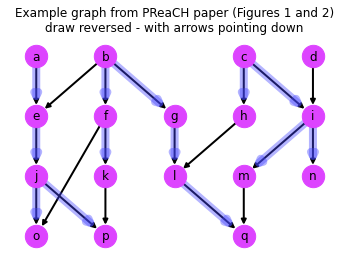

In [ ]:
plt.axis("off")
plt.title('Example graph from PReaCH paper (Figures 1 and 2)\ndraw reversed - with arrows pointing down')
nx.draw_networkx(ch,pos={key:(value[0],-value[1]) for (key,value) in ch.pos.items()},
                 node_size=500,width=2.0,node_color='#dd44ff')
nx.draw_networkx_edges(ch,pos={key:(value[0],-value[1]) for (key,value) in ch.pos.items()},
                       edgelist=find_dfs_spanning(ch),
                       node_size=500,
                       width=8.0,edge_color='#4444ff',alpha=0.4,arrowstyle='->')
plt.show()

In [ ]:
# test unreachable
stats = {}
result = generic_is_reachable_bfs(ch, 'a', 'g', stats=stats)
print('r(%s,%s)=%r in %d steps (naive)\n' %
      ('a', 'g', result, stats['access']))
stats

r(a,g)=False in 4 steps (naive)



{'negative-cut': {'visited': []},
 'depth': {'a': 0, 'e': 1, 'j': 2, 'o': 3, 'p': 3},
 'prev': {'a': None, 'e': 'a', 'j': 'e', 'o': 'j', 'p': 'j'},
 'access': 4,
 'walk': ['a', 'e', 'j', 'o', 'p'],
 'max_queue_size': 2,
 'visited': {'a', 'e', 'j', 'o', 'p'}}

In [ ]:
# test unreachable
stats = {}
result = generic_is_reachable_bfs(ch, 'a', 'g', l=ch.lvl, stats=stats)
print('r(%s,%s)=%r in %d steps (level)\n' %
      ('a', 'g', result, stats['access']))
stats

r(a,g)=False in 1 steps (level)



{'negative-cut': {'level_lite': [], 'level_full': ['e'], 'visited': []},
 'depth': {'a': 0, 'e': 1},
 'prev': {'a': None, 'e': 'a'},
 'access': 1,
 'walk': ['a', 'e'],
 'max_queue_size': 1,
 'visited': {'a', 'e'}}

In [ ]:
# test reachable
stats = {}
u='b'
v='o'
#u='c'
#v='q'
result = generic_is_reachable_bfs(ch, u, v, stats=stats)
print('r(%s,%s)=%r in %d steps (naive)\n  %r\n' %
      (u, v, result, stats['access'], stats))
stats = {}
result = generic_is_reachable_bfs(ch, u, v, II=ch.mpi, stats=stats)
print('r(%s,%s)=%r in %d steps (min-post)\n  %r\n' %
      (u, v, result, stats['access'], stats))
stats = {}
result = generic_is_reachable_bfs(ch, u, v, l=ch.lvl, stats=stats)
print('r(%s,%s)=%r in %d steps (level)\n  %r\n' %
      (u, 'g', result, stats['access'], stats))
stats = {}
result = generic_is_reachable_bfs(ch, u, v, II=ch.mpi, l=ch.lvl, stats=stats)
print('r(%s,%s)=%r in %d steps (min-post + level)\n  %r' %
      (u, v, result, stats['access'], stats))

r(b,o)=True in 9 steps (naive)
  {'negative-cut': {'visited': []}, 'depth': {'b': 0, 'e': 1, 'f': 1, 'g': 1, 'j': 2, 'o': 3, 'k': 2, 'l': 2, 'p': 3}, 'prev': {'b': None, 'e': 'b', 'f': 'b', 'g': 'b', 'j': 'e', 'o': 'j', 'k': 'f', 'l': 'g', 'p': 'j'}, 'access': 9, 'walk': ['b', 'e', 'f', 'g', 'j', 'o'], 'max_queue_size': 5, 'visited': {'e', 'o', 'b', 'f', 'g', 'j'}, 'path': ['b', 'e', 'j', 'o'], 'len': 3}

r(b,o)=True in 3 steps (min-post)
  {'negative-cut': {'visited': []}, 'depth': 1, 'prev': {'b': None, 'e': 'b', 'f': 'b', 'g': 'b'}, 'access': 3, 'walk': ['b', 'e'], 'max_queue_size': 3, 'visited': {'b', 'e'}, 'positive-cut': {'type': 'min-post', 'node': 'e'}, 'path-pre': ['b', 'e'], 'path-post': ['e', 'j', 'o'], 'len-pre': 1, 'len-post': 2, 'path': ['b', 'e', 'j', 'o'], 'len': 3}

r(b,g)=True in 9 steps (level)
  {'negative-cut': {'level_lite': [], 'level_full': [], 'visited': []}, 'depth': {'b': 0, 'e': 1, 'f': 1, 'g': 1, 'j': 2, 'o': 3, 'k': 2, 'l': 2, 'p': 3}, 'prev': {'b': None, 

crown DAG: <networkx.classes.digraph.DiGraph object at 0x000001BF2EA3F130>
- r(u,v): False
- r(1,2): True


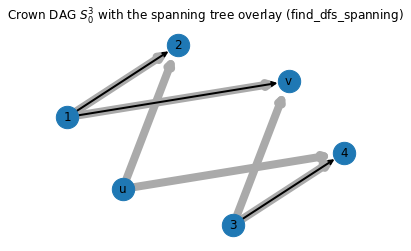

In [ ]:
#@title test generic_is_reachable_large_bfs { form-width: "30%" }

# lazy generation of the graph
try:
    DG
except NameError:
    DG=graphs.crown_DAG()

recalculate = False
if recalculate or not hasattr(DG, 'lvl'):
    DG.lvl = find_levels(DG)
if recalculate or not hasattr(DG, 'mpi'):
    DG.mpi = find_dfs_intervals(DG)

if recalculate or not hasattr(DG, 'pos'):
    DG.pos={1:(1,4),2:(3,6),'u':(2,2),3:(4,1),4:(6,3),'v':(5,5)}
if recalculate or not hasattr(DG, 'span'):
    DG.span=find_dfs_spanning(DG)
    
# configure plot
plt.axis('off')
plt.title('Crown DAG $S_0^3$ with the spanning tree overlay '+
          '(find_dfs_spanning)')

# draw graph and its spanning tree
nx.draw_networkx(DG,
                 pos=DG.pos,
                 node_size=500,width=8.0,
                 edge_color='#aaaaaa')
nx.draw_networkx_edges(DG,
                       pos=DG.pos,
                       edgelist=DG.span,
                       node_size=500,width=2.0,
                       arrowstyle='->')
plt.draw()
    
print('crown DAG: %r' % DG)
print('- r(u,v): %r' % 
      generic_is_reachable_bfs(DG,'u','v',
                               l=DG.lvl,II=DG.mpi))
print('- r(1,2): %r' %
      generic_is_reachable_bfs(DG, 1,  2,
                               l=DG.lvl,II=DG.mpi))

> TODO:
> - examine other example graphs, or
> - create interactive visualization
> - examine paths, cutoffs, etc

----

In [ ]:
#hide
# this should be the last cell of the notebook
from nbdev.export import notebook2script
notebook2script()

Converted 01_tools.ipynb.
Converted 02_related.ipynb.
Converted 03_example_graphs.ipynb.
Converted 05_reachability_index.ipynb.
Converted 06_levels.ipynb.
Converted 07_interval_labels.ipynb.
Converted 08_reach.ipynb.
Converted index.ipynb.
